In [14]:
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import torch

# import numpy as np
from PIL import Image, ImageSequence

In [15]:
from scipy.ndimage import gaussian_filter

def mask_and_blur_images(array):
    '''
    masks signal inside radius of 14 and outside radius of 30 and adds gaussian blur for all intensity data
    array = (128,128) intensity array
    '''
    x,y = np.meshgrid(np.arange(128), np.arange(128))
    radius = np.sqrt((x-64)**2 + (y-62)**2)
    mask1 = radius <= 14
    mask2 = radius >= 30
    masked_data = array.copy()
    masked_data[mask1] = 0
    masked_data2 = masked_data.copy()
    masked_data2[mask2] = 0
    # masked_data_norm = (masked_data - np.min(masked_data) / (np.max(masked_data) - np.min(masked_data)))
    blurred_data = gaussian_filter(masked_data2, sigma=.65)
    array = blurred_data
    return array

In [16]:
def project_theta(theta, m_values):
    """
    Project given 2D vectors onto sin(m*theta) and cos(m*theta) for various m values.
    
    Parameters:
    vectors (np.ndarray): Array of shape (N, 2) representing N 2D vectors.
    m_values (list or np.ndarray): Array of m values for projection.
    
    Returns:
    projections (dict): Dictionary with m values as keys and the projected vectors as values.
                        Each projected vector is an array of shape (N, 2).
    """
    projections = []
    
    for m in m_values:
        sin_m_theta = torch.sin(m * theta)
        cos_m_theta = torch.cos(m * theta)
        
        # Form new vectors using the basis functions
        projected_vectors = torch.stack((cos_m_theta, sin_m_theta), axis=-1)
        
        projections.append(projected_vectors)
    
    return torch.stack(projections, axis=0)

coeff_list = [(1,0)]
theta = 45 * torch.pi / 180
image_shape = (128,128)
center = (64,64)
m_vals = torch.tensor([6])
# m_vals = list(torch.arange(0,3))

x = (project_theta(theta, m_vals))
print(x)
# plt.imshow(x)
# plt.colorbar()

tensor([[ 1.1925e-08, -1.0000e+00]])


torch.Size([128, 128])


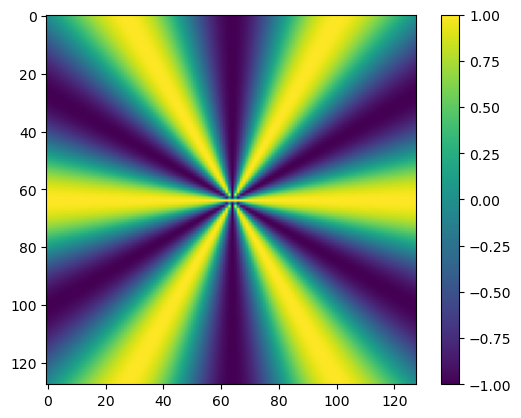

In [17]:
import torch

def evaluate_functions_on_image(image_shape, coefficients_list, m_values, center):
    """
    Evaluate the functions defined by coefficients for sin(m*theta) and cos(m*theta)
    on an image of a specific shape, centered at a given coordinate.

    Parameters:
    image_shape (tuple): Shape of the image (height, width).
    coefficients_list (list of tuples): List of coefficients for the sin and cos functions [(a_sin, a_cos), ...].
    m_values (list): List of m values for the basis functions.
    center (tuple): The center coordinate (x_center, y_center).

    Returns:
    torch.Tensor: 2D tensor of the evaluated function.
    """
    height, width = image_shape
    x_center, y_center = center

    # Create coordinate grid
    y, x = torch.meshgrid(torch.arange(height) - y_center, torch.arange(width) - x_center, indexing='ij')
    
    # Compute theta for each coordinate
    theta = torch.atan2(y.float(), x.float())
    
    # Initialize the evaluated function image
    evaluated_function = torch.zeros(image_shape, dtype=torch.float32)
    
    # Sum contributions from each m
    for (a_cos, a_sin), m in zip(coefficients_list, m_values):
        evaluated_function += a_sin * torch.sin(m * theta) + a_cos * torch.cos(m * theta)
    
    return evaluated_function

y = evaluate_functions_on_image((128,128), coeff_list, m_vals, center)
print(y.shape)
plt.imshow(y)
plt.colorbar()

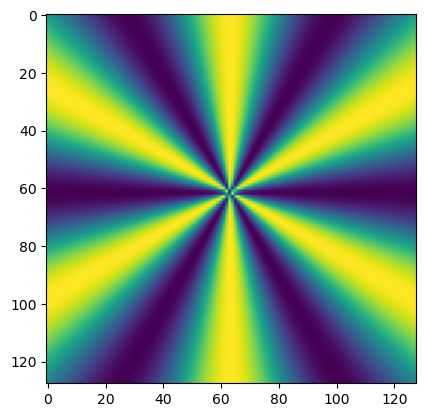

In [18]:
def evaluate_functions_on_theta(theta, coefficients_list, m_values):
    """
    Evaluate the functions defined by coefficients for sin(m*theta) and cos(m*theta)
    on an image of a specific shape, centered at a given coordinate.

    Parameters:
    image_shape (tuple): Shape of the image (height, width).
    coefficients_list (list of tuples): List of coefficients for the sin and cos functions [(a_sin, a_cos), ...].
    m_values (list): List of m values for the basis functions.
    center (tuple): The center coordinate (x_center, y_center).

    Returns:
    torch.Tensor: 2D tensor of the evaluated function.
    """

    # Initialize the evaluated function image
    evaluated_function = torch.zeros(theta.shape, dtype=torch.float32)
    
    # Sum contributions from each m
    for (a_cos, a_sin), m in zip(coefficients_list, m_values):
        evaluated_function += a_sin * torch.sin(m * theta) + a_cos * torch.cos(m * theta)
    
    return evaluated_function

z = evaluate_functions_on_theta(data_theta, coeff_list, m_vals)
plt.imshow(z)

### Note, I think the columns and rows are showing x vs y respectively (opposite how we normally plot)
#### We can double check this later

(3, 128, 128)


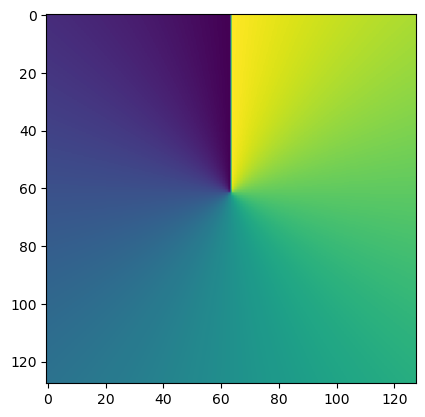

In [31]:
# Load data
# data = np.load('image1.npz')['data']
# data = np.load('images/image_111001.npz')['data']
data = np.load('images/image_111019.npz')['data']

# Split into theta and intensity

# atan2(y, x)
data_theta = torch.atan2(torch.tensor(data[1]), torch.tensor(data[0]))
data_intensity = torch.tensor(data[2])
print(data.shape)
plt.imshow(data_theta)
# plt.colorbar()

torch.Size([128, 128])


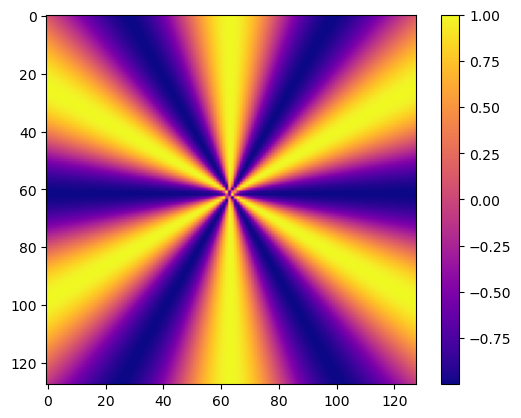

In [20]:
# Example for just cos(6\theta)
evaluate_image_theta = evaluate_functions_on_theta(data_theta, np.array([[1, 0]]), [6])
plt.imshow(evaluate_image_theta.detach(), cmap='plasma')
plt.colorbar()
print(evaluate_image_theta.shape)

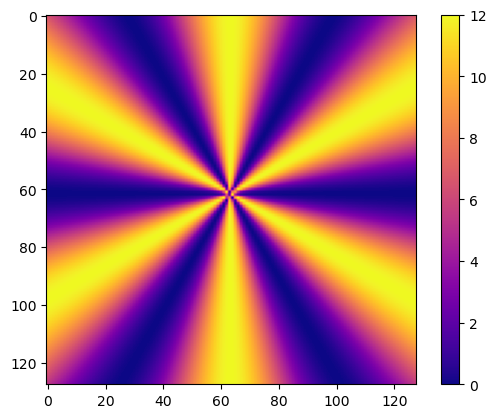

In [39]:
# Set of ms -- reduce for broader angles
ms = torch.arange(12)

# six-fold signa
angles = torch.arange(0, 6) * 2 * torch.pi / 6.

# Projection onto circular harmonics (cos(m\theta), sin(m\theta))
projection = project_theta(angles, ms).sum(1)

evaluate_image_theta = evaluate_functions_on_theta(data_theta, projection, ms)
plt.imshow(evaluate_image_theta.detach(), cmap='plasma')
plt.colorbar()

## Load data and optimize offset

In [78]:
max_iter = 401


# prev_offset = torch.tensor(1.4)
prev_offset = 1.5
offset = torch.tensor(0.001)
offset.requires_grad = True
opt = torch.optim.Adam([offset], lr=1e-1)

for i in range(max_iter):
    projection = project_theta(angles + offset**2 + prev_offset, ms).sum(1)
    evaluate_image_theta = evaluate_functions_on_theta(data_theta, projection, ms)
    loss = -(data_intensity * evaluate_image_theta).sum()
    opt.zero_grad()
    loss.backward()
    opt.step()
    if i % 100 == 0:
        print("loss: ", loss.item(), " offset angle: ", offset.item() * 180/torch.pi)

# plt.imshow(data_intensity)


loss:  -2270564.7604062734  offset angle:  -5.672281287285652
loss:  -2270566.076254652  offset angle:  0.005976680660498958
loss:  -2270565.9881765237  offset angle:  2.440055273948136e-05
loss:  -2270565.9881765237  offset angle:  -7.095935047646132e-07
loss:  -2270565.9881765237  offset angle:  -3.941389081743136e-09


tensor(0.3979, requires_grad=True)


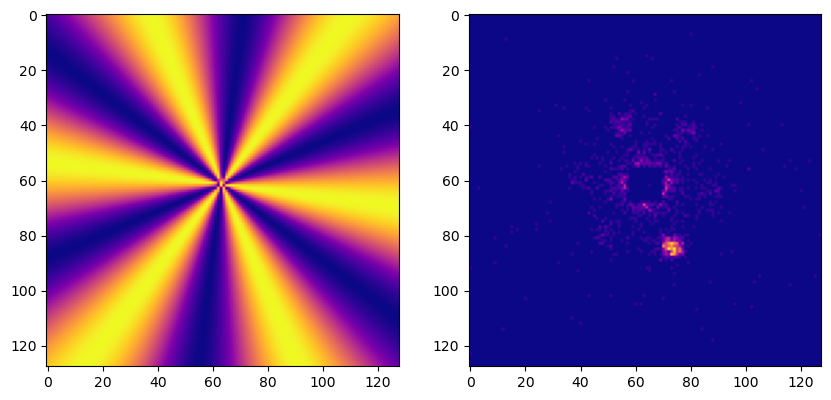

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
print(offset)
ax[0].imshow(evaluate_image_theta.detach(), cmap='plasma')
ax[1].imshow(data_intensity.detach(), cmap='plasma')

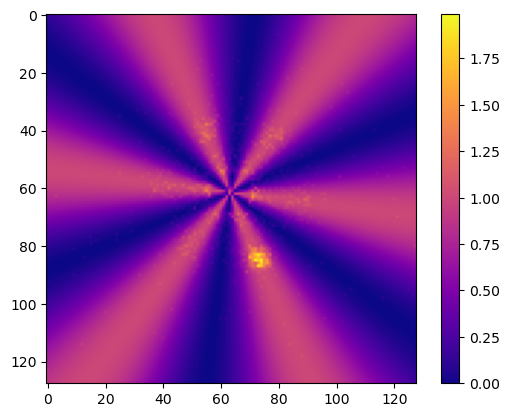

In [49]:
plt.imshow((evaluate_image_theta / evaluate_image_theta.abs().max() + data_intensity / data_intensity.abs().max()).detach(), cmap='plasma')
plt.colorbar()

In [51]:
data_intensity.abs().max()

tensor(2778.6777, dtype=torch.float64)

In [54]:
offset

tensor(0.3979, requires_grad=True)

In [55]:
# evaluated_image = evaluate_functions_on_image(image_shape, projection, m_values, center)
evaluated_image = evaluate_functions_on_image(image_shape, np.array([[1, 0]]), [6], center)

## Zero location roughly

In [28]:
data[0][64, 64]

0.0010344135816536635

In [29]:
data[1][64, 64]

0.00031074327217771205

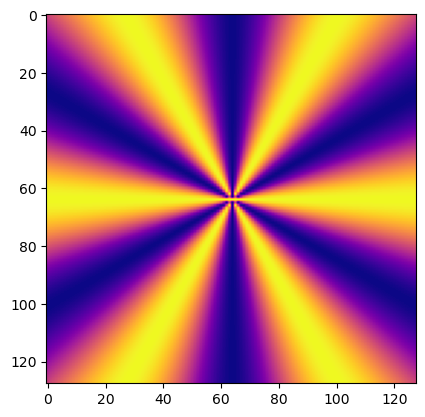

In [30]:
plt.imshow(evaluated_image, cmap='plasma')